In [1]:
# from 
# https://gist.githubusercontent.com/piyueh/712ec7d4540489aad2dcfb80f9a54993/raw/f8121b52fca3518435833761bf5e8c3c706efce1/tf_keras_tfp_lbfgs.py

In [2]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2019 Pi-Yueh Chuang <pychuang@gwu.edu>
#
# Distributed under terms of the MIT license.

"""An example of using tfp.optimizer.lbfgs_minimize to optimize a TensorFlow model.

This code shows a naive way to wrap a tf.keras.Model and optimize it with the L-BFGS
optimizer from TensorFlow Probability.

Python interpreter version: 3.6.9
TensorFlow version: 2.0.0
TensorFlow Probability version: 0.8.0
NumPy version: 1.17.2
Matplotlib version: 3.1.1
"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.

    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.

    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)



# main

In [27]:
# use float64 by default
tf.keras.backend.set_floatx("float64")

# prepare training data

def gen_test_data():
    x = numpy.linspace(-1, 1, 100)[:, numpy.newaxis]
    y = numpy.cos(20*x) + numpy.sin(10*x)
#     y = numpy.cos(50*x) + numpy.sin(5*x)
    return x, y

inps, outs = gen_test_data()

# # # sample data
# inps = tf.range(1, 11, dtype=tf.float64)[:, tf.newaxis].numpy()
# outs = inps**2


# inps = numpy.linspace(0, 1, 1000)[:, numpy.newaxis]
# outs = numpy.sin(inps/0.2)


In [28]:
inps.shape

(100, 1)

In [29]:
outs.shape

(100, 1)

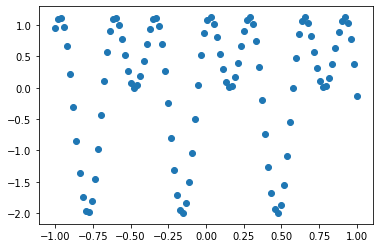

In [30]:
pyplot.figure()
pyplot.scatter(inps[:,0], outs[:,0])

In [75]:
# prepare prediction model, loss function, and the function passed to L-BFGS solver
pred_model = tf.keras.Sequential(
    [tf.keras.Input(shape=[1,]),
     tf.keras.layers.Dense(100, "tanh"),
     tf.keras.layers.Dense(100, "tanh"),
     tf.keras.layers.Dense(1, None)])

loss_fun = tf.keras.losses.MeanSquaredError()
func = function_factory(pred_model, loss_fun, inps, outs)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func, initial_position=init_params, max_iterations=500)


Iter: 1 loss: 0.97688746452331543
Iter: 2 loss: 1.2173305749893188
Iter: 3 loss: 0.96474540233612061
Iter: 4 loss: 0.96364784240722656
Iter: 5 loss: 0.963640034198761
Iter: 6 loss: 0.96363776922225952
Iter: 7 loss: 0.96362894773483276
Iter: 8 loss: 0.963590681552887
Iter: 9 loss: 0.96353882551193237
Iter: 10 loss: 0.96353048086166382
Iter: 11 loss: 0.96332418918609619
Iter: 12 loss: 0.96259307861328125
Iter: 13 loss: 0.960594654083252
Iter: 14 loss: 2.048015832901001
Iter: 15 loss: 0.96058893203735352
Iter: 16 loss: 0.97265815734863281
Iter: 17 loss: 0.96021354198455811
Iter: 18 loss: 0.9657856822013855
Iter: 19 loss: 0.95976471900939941
Iter: 20 loss: 0.9595792293548584
Iter: 21 loss: 0.95928734540939331
Iter: 22 loss: 0.96021467447280884
Iter: 23 loss: 0.95893776416778564
Iter: 24 loss: 0.95823103189468384
Iter: 25 loss: 0.97352594137191772
Iter: 26 loss: 0.95822876691818237
Iter: 27 loss: 0.95749878883361816
Iter: 28 loss: 0.96922338008880615
Iter: 29 loss: 0.95749711990356445
Iter:

In [86]:
# train the model with L-BFGS solver
for i in range(3):
    print(f"i = {i}")
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func, initial_position=results.position, max_iterations=500, tolerance=1e-50, x_tolerance=1e-50, parallel_iterations=4)

i = 0
Iter: 10245 loss: 1.4047750482859556e-05
Iter: 10246 loss: 0.0012569519458338618
Iter: 10247 loss: 1.4045554053154774e-05
Iter: 10248 loss: 1.4044873751117848e-05
Iter: 10249 loss: 1.4052741789782885e-05
Iter: 10250 loss: 1.4044862837181427e-05
Iter: 10251 loss: 1.4044204363017343e-05
Iter: 10252 loss: 1.4042904695088509e-05
Iter: 10253 loss: 1.4068449672777206e-05
Iter: 10254 loss: 1.4042892871657386e-05
Iter: 10255 loss: 1.4041907888895366e-05
Iter: 10256 loss: 1.4042365364730358e-05
Iter: 10257 loss: 1.4041239410289563e-05
Iter: 10258 loss: 1.404022714268649e-05
Iter: 10259 loss: 1.404457725584507e-05
Iter: 10260 loss: 1.4040018868399784e-05
Iter: 10261 loss: 1.4039002962817904e-05
Iter: 10262 loss: 1.4038771951163653e-05
Iter: 10263 loss: 1.4038117114978377e-05
Iter: 10264 loss: 1.4036354514246341e-05
Iter: 10265 loss: 1.4038149856787641e-05
Iter: 10266 loss: 1.4035368621989619e-05
Iter: 10267 loss: 1.40340252983151e-05
Iter: 10268 loss: 1.4033401384949684e-05
Iter: 10269 los

In [87]:
results.converged

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [88]:
# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# do some prediction
pred_outs = pred_model.predict(inps)
err = numpy.abs(pred_outs-outs)
print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(len(inps))))

L2-error norm: 0.002051848281732014


In [89]:
# 0.0012

In [90]:
pyplot.figure()
pyplot.plot(inps, outs)
pyplot.plot(inps, pred_outs, ls='--')
pyplot.show()
pyplot.close()

In [91]:
# mse = tf.keras.losses.MSE(outs, pred_outs)

In [92]:
pyplot.rc('xtick',labelsize=18)
pyplot.rc('ytick',labelsize=18)

In [95]:
pyplot.figure(figsize=(14, 7))
pyplot.scatter(inps, mse)
pyplot.scatter(inps, tf.keras.losses.MSE(outs, pred_outs))
pyplot.yscale('log')
pyplot.ylim(1e-10, 1e-1)

pyplot.axhline(1e-6, color='k', ls='--')

pyplot.show()

pyplot.close()